In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import pandas as pd
import numpy as np
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import recall_score, precision_score, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from src.utils.io_utils import load_model
from src.utils.logger import logger
from src.ml.skipgram import SkipGram

In [3]:
dataset = 'electronics'

### Load data and models

In [4]:
val = pd.read_csv('../data/{}_edges_val.csv'.format(dataset), dtype={'product1': 'object', 'product2': 'object', 'edge':'int8'})

In [5]:
val.head()

,product1,product2,edge
0,b0002xhbys,b000mx5xpm,1
1,b000hdjt4s,b00glzuxnc,1
2,b0026k9l3o,b00855b5qa,1
3,b00009wc1t,b003fxkxk6,1
4,b004rxkwi6,b0089syu9c,1


In [6]:
word2id = load_model('../model/word2id')

2019-12-05 14:30:48,384 - Model loaded from: ../model/word2id (Size: 57402775 bytes)


In [7]:
skipgram = SkipGram(len(word2id), 128)

In [8]:
skipgram.load_state_dict(torch.load('../model/skipgram_epoch_0_2019-12-05-0630.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
w2v = skipgram.center_embeddings.weight.cpu().data.numpy()

### Get product vectors and calculate cosine similarity

In [10]:
def get_product_id(x):
    return word2id.get(x, -1)
word2id_func = np.vectorize(get_product_id)

In [11]:
val['product1id'] = word2id_func(val['product1'].values)
val['product2id'] = word2id_func(val['product2'].values)
val.drop(columns=['product1', 'product2'], inplace=True)

In [12]:
# # Too memory intensive
# val_without_emb = val[(val['product1_id'] == -1) | (val['product2_id'] == -1)].copy()
# val = val[(val['product1_id'] > -1) & (val['product2_id'] > -1)].copy()  # With embedding

# product1_emb = skipgram.get_center_emb(torch.LongTensor(val['product1_id'].values))
# product2_emb = skipgram.get_center_emb(torch.LongTensor(val['product2_id'].values))

# val['score'] = F.cosine_similarity(product1_emb, product2_emb)

In [13]:
# Uses too much memory
# def calculate_cosine_similarity4(val):
#     product1id = val['product1id']
#     product2id = val['product2id']
    
#     if (product1id == -1) or (product2id == -1):
#         return 0.5
#     else:
#         product1_emb = skipgram.get_center_emb(torch.LongTensor(product1id)).detach().numpy()
#         product2_emb = skipgram.get_center_emb(torch.LongTensor(product2id)).detach().numpy()
#         return np.inner(product1_emb, product2_emb) / (np.linalg.norm(product1_emb) * np.linalg.norm(product2_emb))

In [14]:
def calculate_cosine_similarity(val):
    product1id = val['product1id']
    product2id = val['product2id']
    
    if (product1id == -1) or (product2id == -1):
        return 0.5
    else:
        return 1 - spatial.distance.cosine(w2v[val['product1id']], w2v[val['product2id']])

In [15]:
def calculate_cosine_similarity2(val):
    product1id = val['product1id']
    product2id = val['product2id']
    
    if (product1id == -1) or (product2id == -1):
        return 0.5
    else:
        return np.inner(w2v[product1id], w2v[product2id]) / (np.linalg.norm(w2v[product1id]) * np.linalg.norm(w2v[product2id]))

In [16]:
def calculate_cosine_similarity3(val):
    product1id = val['product1id']
    product2id = val['product2id']
    
    return cosine_similarity([w2v[product1id]], [w2v[product2id]])

In [17]:
# # This is correct implementation
# def calculate_cosine_similarity2_vectorized(product1id, product2id):
#     if (product1id == -1) or (product2id == -1):
#         return -1 
#     else:
#         return np.inner(w2v[product1id], w2v[product2id]) / (np.linalg.norm(w2v[product1id]) * np.linalg.norm(w2v[product2id]))
    
# cos_sim_func = np.vectorize(calculate_cosine_similarity2_vectorized)

In [18]:
# This is incorrect implementation but suggests that the last vector is a good approx for unseen vecs
# Update: Added vectors for unseen products in skipgram so now this works
def calculate_cosine_similarity2_vectorized(product1id, product2id):
    return np.inner(w2v[product1id], w2v[product2id]) / (np.linalg.norm(w2v[product1id]) * np.linalg.norm(w2v[product2id]))
    
cos_sim_func = np.vectorize(calculate_cosine_similarity2_vectorized)

In [19]:
# %timeit val.head(100).apply(calculate_cosine_similarity, axis=1)

In [20]:
# %timeit val.head(100).apply(calculate_cosine_similarity2, axis=1)

In [21]:
# %timeit val.head(100).apply(calculate_cosine_similarity3, axis=1)

In [22]:
# %timeit val.head(100).apply(calculate_cosine_similarity4, axis=1)

In [23]:
%timeit cos_sim_func(val.head(100)['product1id'].values, val.head(100)['product2id'].values)

1.65 ms ± 48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
val['score'] = cos_sim_func(val['product1id'].values, val['product2id'].values)

In [25]:
# val['score'] = np.where(val['score'] == 1, 0.5, val['score'])

In [26]:
# Set score of unseen item pairs to median score of seen item pairs
val_seen = val[val['score'] != -1]
median_score = np.median(val_seen['score'])
val['score'] = np.where(val['score'] == -1, median_score, val['score'])

### Evaluate results

In [27]:
roc_score = roc_auc_score(val['edge'], val['score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-05 14:32:03,051 - AUC-ROC: 0.9413298814929544


In [28]:
roc_score_seen = roc_auc_score(val_seen['edge'], val_seen['score'])
logger.info('AUC-ROC: {}'.format(roc_score_seen))

2019-12-05 14:32:03,862 - AUC-ROC: 0.9413298814929544


Text(0.5, 1.0, 'PyTorch Word2Vec - AUC-ROC: 0.9413')

/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


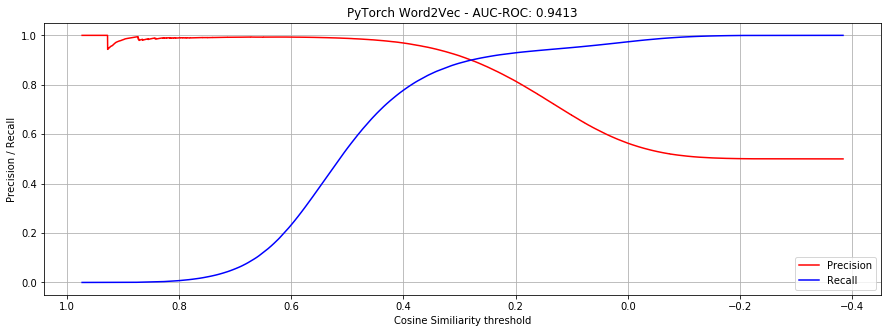

In [29]:
precision, recall, thresholds = precision_recall_curve(val['edge'], val['score'])
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(thresholds, precision[1:], color='r', label='Precision')
plt.plot(thresholds, recall[1:], color='b', label='Recall')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Cosine Similiarity threshold')
plt.ylabel('Precision / Recall')
plt.title('PyTorch Word2Vec - AUC-ROC: {:.4f}'.format(roc_score))

Text(0.5, 1.0, 'PyTorch Word2Vec (seen items only) - AUC-ROC: 0.9413')

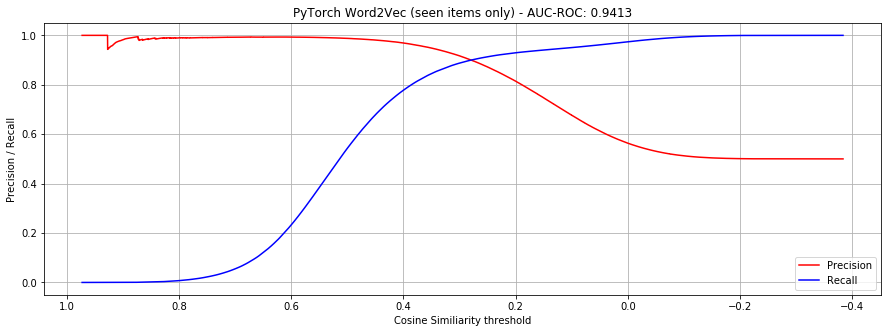

In [30]:
precision, recall, thresholds = precision_recall_curve(val_seen['edge'], val_seen['score'])
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(thresholds, precision[1:], color='r', label='Precision')
plt.plot(thresholds, recall[1:], color='b', label='Recall')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Cosine Similiarity threshold')
plt.ylabel('Precision / Recall')
plt.title('PyTorch Word2Vec (seen items only) - AUC-ROC: {:.4f}'.format(roc_score_seen))

Text(0.5, 1.0, 'ROC curve')

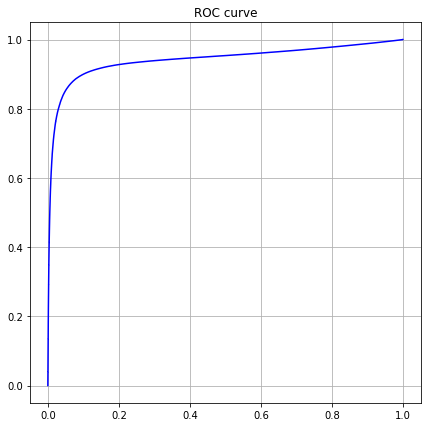

In [31]:
fpr, tpr, roc_thresholds = roc_curve(val['edge'], val['score'])
plt.figure(figsize=(7, 7))
plt.grid()
plt.plot(fpr, tpr, color='b')
plt.title('ROC curve')

Text(0.5, 1.0, 'Precision-Recall Trade-off')

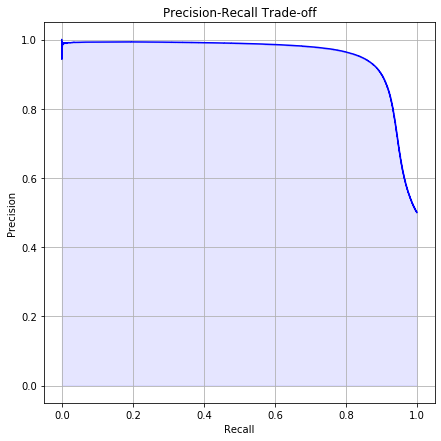

In [32]:
plt.figure(figsize=(7, 7))
plt.grid()
plt.step(recall, precision, color='b', label='Precision-Recall Trade-off')
plt.fill_between(recall, precision, alpha=0.1, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off')